In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier as RFC 
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingClassifier as GBR

#from xgboost.sklearn import XGBClassifier as XGB
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn import metrics
import datetime
from datetime import datetime
import time
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore")

In [15]:
import talib
from talib import MACD
from talib import MFI
from talib import BOP
from talib import CCI
from talib import AROON
from talib import ROCP
from talib import WILLR
from talib import PLUS_DI
from talib import ADX
from talib import TEMA

In [16]:
data = pd.read_csv('../data/ES.txt', sep=",", header = None, engine='python')
#data_cl = pd.read_csv('../data/CL.txt', sep=",", header = None, engine='python')

data.columns = ['date', 'time', 'open ', 'high', 'low', 'close', 'volume']

data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['date', 'time'], ascending = False)

#data_cl['date'] = pd.to_datetime(data['date'])
#data_cl = data_cl.sort_values(['date', 'time'], ascending = False)

In [53]:
data['vol'] = ((data['open ']-data['close'])*(data['high']-data['low']))
data['prox_100'] = data['vol']-100

In [375]:
data_cl = pd.read_csv('../data/CL.txt', sep=",", header = None, engine='python')
data_cl.columns = ['date', 'time', 'open ', 'high', 'low', 'close', 'volume']

data_cl['date'] = pd.to_datetime(data_cl['date'])
data_cl = data_cl.sort_values(['date', 'time'], ascending = False)

In [376]:
data = data_cl

In [32]:
data['time_2'] = data['time']
data['time_2'] = pd.to_datetime(data['time'])
data['hour'] = data['time_2'].dt.hour
data['min'] = data['time_2'].dt.minute
data['sec'] = data['time_2'].dt.second
data['range'] = data['open '] - data['close']

data['volume'] = np.where(data['range'] < 0, data['volume']*(-1), data['volume'])

data = data.sort_values(['date','time'], ascending = True)

data['rsi'] = talib.RSI (data['close'], timeperiod=14)
data['roc'] = talib.ROC(data['close'], timeperiod=14)
data['trix'] = talib.TRIX(data['close'], timeperiod=14)
data['ultosc'] = talib.ULTOSC(data['high'], data['low'], data['close'], timeperiod1=7, timeperiod2=14, timeperiod3=28)
macd, macdsignal, macdhist = MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['macd'] = macd
data['macdsignal'] = macdsignal
data['macdhist'] = macdhist
data['mfi'] = MFI(data['high'], data['low'], data['close'], data['volume'], timeperiod=14)
data['trima'] = talib.TRIMA(data['close'], timeperiod=14)
data['trima'] = talib.TRIMA(data['close'], timeperiod=14)
data['bop'] = BOP(data['open '], data['high'], data['low'], data['close'])
data['cci'] = CCI(data['high'], data['low'], data['close'], timeperiod=14)
aroondown, aroonup = AROON(data['high'], data['low'], timeperiod=14)
data['rocp'] = ROCP(data['close'], timeperiod=10)

data['aroon_down'] = aroondown
data['aroon_up'] = aroonup
data['willr'] = WILLR(data['high'], data['low'], data['close'], timeperiod=14)
data['plus'] = PLUS_DI(data['high'], data['low'], data['close'], timeperiod=14)
data['adx'] = ADX(data['high'], data['low'], data['close'], timeperiod=14)
data['tema'] = TEMA(data['close'], timeperiod=30)

data['range'] = data['close'] - data['open ']

data = data.sort_values(['date','time'], ascending = False)

###################################################################################


data['ultosc_range'] = data['ultosc'].diff(-1)
data['trix_range'] = data['trix'].diff(-1)
data['cci_range'] = data['cci'].diff(-1)
data['aroonup_range'] = data['aroon_up'].diff(-1)
data['aroondown_range'] = data['aroon_down'].diff(-1)
data['willr_range'] = data['willr'].diff(-1)
data['macdhist_range'] = data['macdhist'].diff(-1)
data['mfi_range'] = data['mfi'].diff(-1)
data['adx_range'] = data['adx'].diff(-1)

data['willr_adx_diff'] = data['willr'] - data['adx']



# data['range'] = data['close'] - data['open ']
#data['response'] = data['low']

data['response'] = np.where((data['range'] >= 5), 1, 0)
data['response'] = np.where((data['range'] <= -5), 2, data['response'])

data['response'] = data['response'].shift(1, axis = 0 )

data['index'] = data['date'].astype(str) + data['time'].astype(str)
data = data.set_index(data['index'])



from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')



df_final = data
df_final = df_final.fillna(0)
df_final = df_final.drop('index', axis = 1)
df_final = df_final[~df_final['date'].isnull()]
#df_final = df_final.reset_index(drop = True)

<Figure size 1600x800 with 0 Axes>

In [342]:
def imi(data, n = 21):
    data = data.sort_values(['date','time'], ascending = True)
    delta = data['close'].diff()

    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0
    
  #  dUp = delta[delta>0]
    #dDown = delta[delta<0]

    Rollup = dUp.rolling(n).sum()
    dDown = dDown.rolling(n).sum()

    Rollup = Rollup.reindex_like(delta, method='ffill')

    Rolldown = dDown.reindex_like(delta, method='ffill')

    IMI = (Rollup/(Rollup + abs(Rolldown)))*100

    return IMI


In [378]:
test_up = pd.DataFrame(imi(df_final))
test_up.columns = ['imi']

df_final = pd.merge(df_final, test_up, how = 'left', on = 'index')

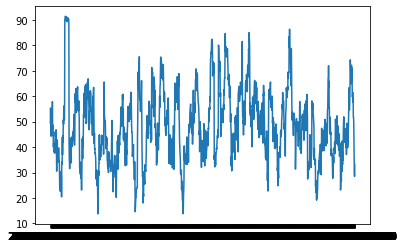

In [355]:
test= pd.DataFrame(test_up)
test = test.sort_values(['index'], ascending = False)
plt.plot(test.index[0:1500], test.close[0:1500])

In [387]:
from collections import Counter

c = Counter()
imi = []

for i in df_final.imi:
    if i < 20:
        c[df_final['buy']] += 1

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [236]:
dUp = pd.DataFrame(test_up)

In [237]:
dUp

,close
index,
2020-04-0815:45,0.02
2020-04-0815:15,0.07
2020-04-0814:15,0.28
2020-04-0814:00,0.31
2020-04-0723:15,0.08
...,...
2010-01-2007:45,0.03
2010-01-2007:30,0.17
2010-01-2005:30,0.07


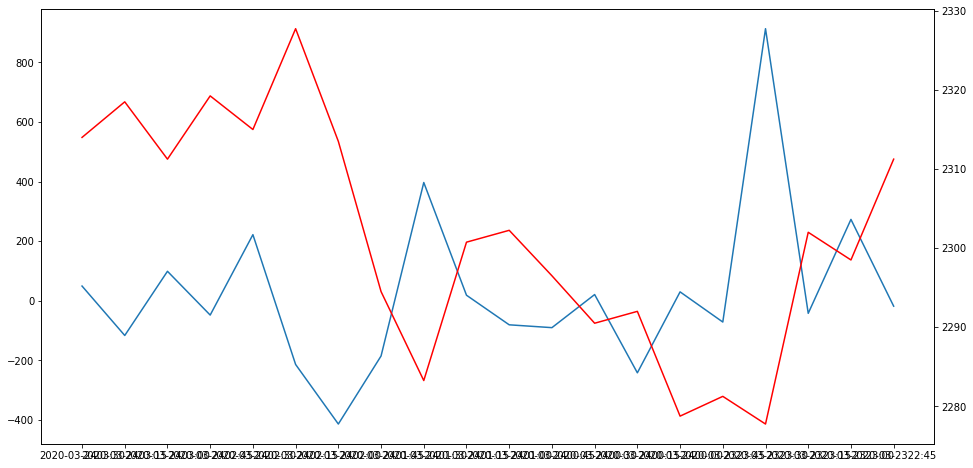

In [54]:
start =1000
stop = 1020

plt.rcParams['figure.figsize'] = (16,8)
plt.plot(data['index'][start:stop], data['vol'][start:stop])
plt.twinx()
plt.plot(data['index'][start:stop], data['close'][start:stop], color = 'red')


In [38]:
df_final = data[['open ','range','close', 'low', 'high', 
                     'volume','hour', 'min', 'rsi','roc','rocp', 
                     'trix', 'ultosc', 'macd', 'macdhist', 'mfi',
                     'trima', 'bop', 'cci','aroon_down', 'aroon_up', 
                     'willr', 'plus','adx','tema','ultosc_range', 
                     'trix_range','cci_range','aroonup_range','aroondown_range' ,
                     'macdhist_range','mfi_range', 'willr_range',
                     'adx_range','vol', 'prox_100','response']] 

In [39]:
features= ['open ', 'volume','hour','range', 'min',
           'rsi','roc','trix', 'ultosc', 'macd', 
           'macdhist', 'mfi','trima', 'tema', 
           'cci', 'aroon_up', 'aroon_down','macdhist_range', 
           'mfi_range', 'willr_range', 'adx_range', 'adx_range','vol', 'prox_100']
response = ['response']

In [41]:
df_final[['prox_100', 'vol', 'close']].corr()

,prox_100,vol,close
prox_100,1.000000,1.000000,-0.001167
vol,1.000000,1.000000,-0.001167
close,-0.001167,-0.001167,1.000000


## Runs model

In [56]:
X = df_final[features]
y = df_final[response]
length = 200000

start_test = 6
stop_test = 7

tested = []
diff = []
diff_mean = []
test = []
gbr_tested = []
xgb_tested = []

model_list = ['rfr', 'xgb']


for i in range(start_test, stop_test, 1):

    #X_test = new_x_test
    X_test = X[i -1:i]
    X_train = X[i+100:length]

    y_test = y[i -1:i]
    y_train = y[i+100:length]

    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)

    rf = RFC(n_estimators = 5,
    random_state = 42,
    min_samples_leaf = 10,
    #n_jobs = 2,
    #min_samples_split = 2,
    warm_start = True,
    bootstrap = True)
    
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    
    #xg = XGB(n_estimators = 100,
    #random_state = 42)
    #xg.fit(X_train, y_train)
    #xg_pred = xg.predict(X_test)
    
    test.append(y_test)
    
    tested.append(rf_pred)
    #xgb_tested.append(xg_pred)

    
        #rf.fit(X_train, y_train)
        #rf_pred = rf.predict(X_test)
        #test.append(y_test)
        #tested.append(rf_pred)
        
    difference = (rf_pred-y_test)
    #diff.append(difference)
    
    if (rf_pred == y_test)&(rf_pred != 0):
        print('GOOD Predicted low for next 15 min ticker: ', rf_pred, y_test, rf_pred-y_test)
        diff.append(1)
        means=sum(diff)/len(diff)
        diff_mean.append(means)
    elif (rf_pred != y_test) &(rf_pred != 0)& (y_test != 0):
        print('BAD Predicted low for next 15 min ticker: ', rf_pred, y_test, rf_pred-y_test)
        diff.append(0)
        means=sum(diff)/len(diff)
        diff_mean.append(means)
    elif (rf_pred != 0):
        print('Predicted non-zero')

    print(i)


GOOD Predicted low for next 15 min ticker:  [2.] [2.] [0.]
6


## Adds new row to df_final

In [291]:
actual = 26.71
predicted = rf_pred

In [292]:
att.append(actual)
df_final.loc[-1] =  att # adding a row
df_final.index = df_final.index + 1  # shifting index
df_final = df_final.sort_index()  # sorting by index
df_final

,open,high,low,close,volume,hour,min,response
0,26.34,26.65,26.31,26.59,12920.0,11.0,30.0,26.43
1,26.54,26.57,26.21,26.34,-18490.0,11.0,15.0,26.31
2,26.51,26.76,26.46,26.54,12650.0,11.0,0.0,26.21
3,26.26,26.73,26.35,26.51,-15000.0,10.0,45.0,26.46
4,26.98,26.99,26.57,26.63,-17900.0,10.0,30.0,26.35
...,...,...,...,...,...,...,...,...
249598,66.36,66.40,66.34,66.40,-46.0,19.0,0.0,66.32
249599,66.40,66.48,66.35,66.37,122.0,18.0,45.0,66.34
249600,66.32,66.42,66.30,66.39,-72.0,18.0,30.0,66.35
249601,66.37,66.42,66.27,66.35,135.0,18.0,15.0,66.30


## Constructs new dataframe 

In [293]:
time = new_x_df['hour'].iloc[0].astype(str) + new_x_df['min'].iloc[0].astype(str)
new = [predicted, actual, time]

new_df.loc[-1] =  new # adding a row
new_df.index = new_df.index + 1  # shifting index
new_df = new_df.sort_index()  # sorting by index
new_df


,predicted,actual,time
0,[26.309099790921152],26.43,11.030.0
1,[26.157864106785315],26.31,11.015.0
2,[26.30016308491639],26.21,11.00.0
3,[26.318027895943068],26.46,10.045.0
4,[26.435749082125607],26.35,10.030.0
5,[26.79277819626996],26.57,10.015.0
6,[27.049179935554008],26.88,10.00.0
7,[27.151400252196993],26.98,9.045.0
8,[27.274291332409383],27.24,9.030.0
9,[26.897100910583667],26.79,9.015.0


## Insert test values:  open, high, low, close, volume, hour, min

In [296]:
open = float(input('Input open value: '))
high = float(input('Input high value: '))
low = float(input('Input low value: '))
close = float(input('Input close value: '))
volume = float(input('Input volume value: '))
hour = float(input('Input hour value: '))
min = float(input('Input min value: '))

Input open value: 26.59
Input high value: 27.39
Input low value: 26.43
Input close value: 27.08
Input volume value: 32390
Input hour value: 11
Input min value: 45


In [297]:
att=[]
att = [open, high, low, close, volume, hour, min]
new_x_test = pd.DataFrame(zip(att)).T
new_x_test.columns = ['open ', 'high_x', 'low_x', 'close_x', 'volume', 'hour', 'min']
new_x_df = new_x_test

## Resets df, only use for first plotted point

In [30]:
time = new_x_df['hour'].iloc[0].astype(str) + new_x_df['min'].iloc[0].astype(str)
new = [predicted, actual, time]
new_df = pd.DataFrame(zip(new)).T
new_df.columns = ['predicted', 'actual', 'time']

## Graphing

In [221]:
new_data_1 = new_df

plt.rcParams['figure.figsize'] = (16,8)
#plt.plot(tested, label = 'predicted')
#plt.plot(new_data_1.index, new_data_1['diff'], label = 'actual')
plt.plot(new_data_1.time, new_data_1.predicted, label = 'predicted', linestyle='--', marker='o')
plt.plot(new_data_1.time, new_data_1['actual'], label = 'actual', linestyle='--', marker='o')
#plt.plot(new_data_1.index, new_data_1['added_features'], label = 'added_features', linestyle='--', marker='o')
#plt.plot(new_data_1.index, new_data_1['xgb_predicted'], label = 'xgb_predicted', linestyle='--', marker='o')

plt.legend(loc="upper left")

plt.xticks(rotation = 90)
plt.grid(True)
#plt.plot(data_1.index, data_1['ewm_50'])
#plt.savefig('oil')
plt.show()

NameError: name 'new_df' is not defined

In [273]:
len(df_final[start_test-1:1200])

201

In [331]:
new_data = df_final[start_test-1 : 3075]
new_data['predicted'] = tested
new_data['predicted'] = new_data['predicted'].astype(float)
#new_data['diff'] = diff
#new_data['diff'] = new_data['diff'].astype(float)
#new_data['diff'] = new_data['diff'].fillna(0)
#bias = new_data['diff'].mean()
#new_data['new_predicted'] = new_data['predicted'] - bias
#new_data['predicted'] = new_data['predicted'].astype(float)

#new_data['new_response'] = new_data['response'] - new_data['new_predicted']
#new_data['new_response'] = new_data['new_response'].shift(-1, axis = 0 )

#new_data['response'] = new_data['low_x']
#new_data['response'] = new_data['response'].shift(1, axis = 0 )
new_data['response'] = test
new_data['response'] = new_data['response'].astype(float)
new_data = new_data.fillna(0)

#new_data['gbr_predicted'] = gbr_tested
#new_data['gbr_predicted'] = new_data['gbr_predicted'].astype(float)

#new_data['xgb_predicted'] = xgb_tested
#new_data['xgb_predicted'] = new_data['xgb_predicted'].astype(float)

#new_data['comb_pred'] = ((new_data['predicted'] + new_data['xgb_predicted'])/2)
#new_data['comb_pred'] = new_data['comb_pred'].astype(float)
#new_data['diff'] = new_data['comb_pred']-new_data['response']
#new_data['diff'] = new_data['diff'].astype(float)

#new_data['diff'] = new_data['diff'].shift(-1, axis = 0 )
#new_data['comb_pred'] = new_data['comb_pred'].shift(-1, axis = 0 )

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)


In [332]:
new_data

,open,range,close,low,high,volume,hour,min,rsi,roc,rocp,trix,ultosc,macd,macdhist,mfi,trima,bop,cci,aroon_down,aroon_up,willr,plus,adx,tema,tema_trima_diff,ultosc_range,trix_range,cci_range,aroonup_range,aroondown_range,macdhist_range,mfi_range,willr_range,tema_trima_range,adx_range,response,predicted
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-2103:45,3357.00,-1.25,3355.75,3352.50,3357.75,17181,3,45,51.581896,0.029808,0.001492,-0.011751,55.436597,-1.988679,0.711640,40.068042,3351.049107,-0.238095,120.647419,78.571429,92.857143,-24.561404,19.770801,36.400982,3350.656549,-0.392558,4.730977,0.000788,-0.347692,-7.142857,-7.142857,0.290211,-5.080374,-7.017544,0.904560,-2.274053,0.0,0.0
2020-02-2103:30,3350.25,6.50,3356.75,3350.25,3359.25,24255,3,30,53.366771,-0.022338,0.001268,-0.012539,50.705620,-2.456800,0.421429,45.148416,3351.209821,0.722222,120.995111,85.714286,100.000000,-17.543860,21.764094,38.675035,3349.912704,-1.297117,6.724296,0.000444,203.653305,92.857143,-7.142857,0.558218,13.072608,44.274322,1.401406,-2.448980,0.0,0.0
2020-02-2103:15,3347.00,3.25,3350.25,3346.25,3351.50,12287,3,15,41.056234,-0.208504,-0.001118,-0.012983,43.981324,-3.120375,-0.136789,32.075808,3351.580357,0.619048,-82.658194,92.857143,7.142857,-61.818182,9.462896,41.124015,3348.881833,-2.698524,1.794856,-0.000180,58.082546,-7.142857,-7.142857,0.173955,8.959358,23.636364,0.342523,0.814454,1.0,0.0
2020-02-2103:00,3350.50,-3.50,3347.00,3345.00,3351.00,21096,3,0,32.822634,-0.275605,-0.002013,-0.012802,42.186468,-3.260133,-0.310745,23.116450,3352.120536,-0.583333,-140.740741,100.000000,14.285714,-85.454545,9.455859,40.309562,3349.079489,-3.041047,-0.275540,-0.000373,-64.211060,14.285714,14.285714,-0.122261,-6.700106,-6.384778,-0.320523,1.178329,1.0,0.0
2020-02-2102:45,3349.75,0.50,3350.25,3349.75,3352.00,3311,2,45,37.714513,-0.215934,-0.001341,-0.012429,42.462008,-3.060186,-0.188484,29.816556,3352.727679,0.222222,-76.529680,85.714286,0.000000,-79.069767,10.776935,39.131232,3350.007155,-2.720524,1.711258,-0.000243,25.859892,0.000000,-7.142857,0.078313,4.735232,8.164275,0.215222,0.262657,2.0,0.0
2020-02-2102:30,3351.75,-2.25,3349.50,3349.00,3351.75,6848,2,30,35.659670,-0.297663,-0.002383,-0.012186,40.750750,-3.091379,-0.266797,25.081325,3353.357143,-0.818182,-102.389573,92.857143,0.000000,-87.234043,10.821331,38.868575,3350.421397,-2.935746,-4.341205,-0.000332,-6.591993,-7.142857,-7.142857,-0.014817,-3.139954,-17.846287,0.031502,0.443165,0.0,0.0
2020-02-2102:15,3348.75,3.00,3351.75,3348.00,3352.25,7679,2,15,39.268558,-0.245536,-0.001638,-0.011854,45.091955,-3.009862,-0.251980,28.221279,3354.044643,0.705882,-95.797580,100.000000,7.142857,-69.387755,11.492099,38.425410,3351.077396,-2.967247,6.476430,-0.000319,28.518754,7.142857,0.000000,0.144261,9.767836,22.448980,0.408358,0.477254,0.0,0.0
2020-02-2102:00,3352.25,-3.25,3349.00,3348.00,3353.00,11175,2,0,31.387903,-0.290287,-0.002160,-0.011535,38.615525,-3.091128,-0.396241,18.453443,3354.763393,-0.650000,-124.316334,100.000000,0.000000,-91.836735,12.614173,37.948156,3351.387787,-3.375606,-0.965673,-0.000475,-54.237771,0.000000,7.142857,-0.122176,-4.503357,-20.725624,-0.196345,0.513966,1.0,0.0
2020-02-2101:45,3352.00,0.50,3352.50,3352.00,3354.50,3753,1,45,37.073298,-0.223214,-0.001489,-0.011059,39.581197,-2.869892,-0.274065,22.956800,3355.517857,0.200000,-70.078563,92.857143,0.000000,-71.111111,14.120304,37.434190,3352.338596,-3.179261,-3.286887,-0.000340,59.776509,-7.142857,-7.142857,0.100758,1.459907,4.975845,0.309694,-0.427998,2.0,0.0


In [333]:
new_data[new_data['predicted'] != 0]

,open,range,close,low,high,volume,hour,min,rsi,roc,rocp,trix,ultosc,macd,macdhist,mfi,trima,bop,cci,aroon_down,aroon_up,willr,plus,adx,tema,tema_trima_diff,ultosc_range,trix_range,cci_range,aroonup_range,aroondown_range,macdhist_range,mfi_range,willr_range,tema_trima_range,adx_range,response,predicted
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-2013:00,3359.50,8.00,3367.50,3357.25,3367.75,50219,13,0,45.503572,-0.421379,-0.006197,-0.023300,61.935453,-6.501588,-1.399467,32.391288,3367.227679,0.761905,-24.617737,57.142857,35.714286,-43.216080,16.450619,40.642947,3360.106849,-7.120829,9.771130,-0.001807,39.253682,-7.142857,-7.142857,1.133827,-2.558858,16.582915,3.753604,-0.484837,2.0,2.0
2020-02-2012:30,3352.00,0.50,3352.50,3349.25,3356.00,52839,12,30,23.562383,-0.798935,-0.010551,-0.018436,45.353851,-7.340195,-3.221264,33.045544,3374.200893,0.074074,-95.147890,71.428571,50.000000,-73.366834,6.351762,39.798769,3361.130477,-13.070416,0.743923,-0.003782,18.719945,-7.142857,-7.142857,0.081026,-2.672437,1.005025,0.119091,2.575603,1.0,2.0
2020-02-2012:15,3357.00,-5.00,3352.00,3350.00,3357.25,59712,12,15,22.637427,-0.791713,-0.009749,-0.014654,44.609928,-6.615904,-3.302290,35.717981,3377.339286,-0.689655,-113.867835,78.571429,57.142857,-74.371859,6.829628,37.223167,3364.149779,-13.189507,-2.922290,-0.003821,24.204494,-7.142857,-7.142857,-0.246025,-1.748172,-10.050251,-1.242701,2.739561,0.0,1.0
2020-02-2011:45,3355.75,1.25,3357.00,3350.50,3363.25,99423,11,45,25.503068,-0.665779,-0.006731,-0.007342,41.903696,-4.605004,-2.881029,39.770624,3381.258929,0.098039,-172.082086,92.857143,71.428571,-64.321608,8.239764,31.533309,3370.864803,-10.394126,0.409095,-0.003221,128.388640,-7.142857,-7.142857,-0.545616,7.618169,2.512563,-2.691367,3.083361,0.0,2.0
2020-02-2011:30,3362.00,-6.25,3355.75,3339.25,3364.25,267353,11,30,23.413198,-0.761496,-0.007028,-0.004121,41.494601,-3.339131,-2.335413,32.152455,3382.156250,-0.250000,-300.470727,100.000000,78.571429,-66.834171,9.550824,28.449947,3374.453491,-7.702759,7.462603,-0.002541,-42.692949,-7.142857,0.000000,-1.207703,-15.773854,32.248398,-4.101076,3.320543,0.0,1.0
2020-02-2011:00,3386.50,-10.25,3376.25,3376.00,3386.75,56787,11,0,39.415964,-0.096168,-0.000370,-0.000421,47.183812,0.125249,0.263187,62.306542,3382.178571,-0.953488,-55.776892,28.571429,92.857143,-92.727273,17.231316,22.934250,3382.545446,0.366874,-13.166205,0.000386,-167.434973,-7.142857,-7.142857,-0.748197,-8.309915,-74.545455,-1.902276,0.253359,2.0,2.0


In [381]:
new_data['diff'] = new_data['predicted'] - new_data['response']

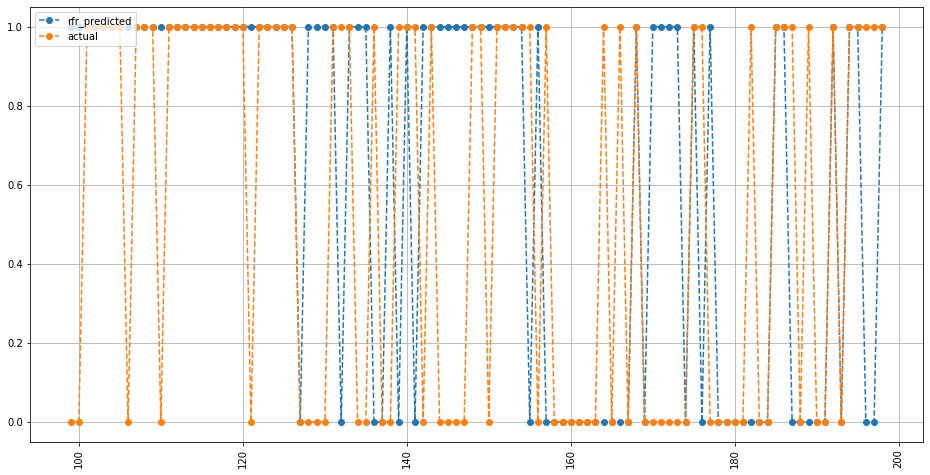

In [457]:
new_data_1 = new_data

plt.rcParams['figure.figsize'] = (16,8)
#plt.plot(tested, label = 'predicted')
#plt.plot(new_data_1.index, new_data_1['diff'], label = 'actual')
plt.plot(new_data_1.index, new_data_1.predicted, label = 'rfr_predicted', linestyle='--', marker='o')
plt.plot(new_data_1.index, new_data_1['response'], label = 'actual', linestyle='--', marker='o')
#plt.plot(new_data_1.index, new_data_1['new_predicted'], label = 'new_predicted', linestyle='--', marker='o')
#plt.plot(new_data_1.index, new_data_1['xgb_predicted'], label = 'xgb_predicted', linestyle='--', marker='o')

plt.legend(loc="upper left")

plt.xticks(rotation = 90)
plt.grid(True)
#plt.plot(data_1.index, data_1['ewm_50'])
#plt.savefig('oil')
plt.show()

In [1080]:
import pickle
# save the model to disk
filename = 'rfr_model.sav'
pickle.dump(rf, open(filename, 'wb')) 

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [251]:
X_train.columns

Index(['open ', 'high', 'low', 'close', 'volume', 'hour', 'hour', 'min', 'min',
       'rsi', 'rocr', 'trix', 'ultosc', 'macd', 'macdsignal', 'macdhist'],
      dtype='object')

In [57]:

features = X_train.columns

feature_imp = (rf.feature_importances_)

importances = pd.DataFrame([features,feature_imp])

final = importances.transpose()

final.columns = ['Features', 'Importance %']

final = final.sort_values(by = 'Importance %', ascending = False)

final = final.set_index('Features')

print(final[0:20])

#graph = final['Importance %'].plot(kind = 'bar', color = 'r', alpha = .5,figsize=(20,10),label = 'Actual Strategy Outcomes (from test data)')

               Importance %
Features                   
vol                 0.13925
prox_100          0.0889746
macd              0.0735269
macdhist_range    0.0708414
macdhist          0.0627709
range             0.0617709
roc               0.0500655
volume            0.0423796
open              0.0385574
trima             0.0367674
trix              0.0336126
rsi               0.0324121
tema              0.0322874
willr_range       0.0299816
mfi_range         0.0298847
cci               0.0282254
ultosc            0.0275528
hour              0.0251363
mfi               0.0238513
adx_range         0.0218705


In [323]:
data['doji'] = talib.CDLDOJI(data['open '],data['high'],data['low'],data['close'])
data['3blkcrows'] = talib.CDL3BLACKCROWS(data['open '],data['high'],data['low'],data['close'])
data['tristar'] = talib.CDLTRISTAR(data['open '],data['high'],data['low'],data['close'])
data['marubozu'] = talib.CDLMARUBOZU(data['open '],data['high'],data['low'],data['close'])
data['kickingbylength'] = talib.CDLMARUBOZU(data['open '],data['high'],data['low'],data['close'])
data['gap3methods'] = talib.CDLXSIDEGAP3METHODS(data['open '],data['high'],data['low'],data['close'])
data['upsidegap2crows'] = talib.CDLUPSIDEGAP2CROWS(data['open '],data['high'],data['low'],data['close'])
data['unique3river'] = talib.CDLUNIQUE3RIVER(data['open '],data['high'],data['low'],data['close'])
data['thrustingpattern'] = talib.CDLTHRUSTING(data['open '],data['high'],data['low'],data['close'])
data['tasukigap'] = talib.CDLTASUKIGAP(data['open '],data['high'],data['low'],data['close'])
data['takuri'] = talib.CDLTAKURI(data['open '],data['high'],data['low'],data['close'])
data['sticksandwich'] = talib.CDLSTICKSANDWICH(data['open '],data['high'],data['low'],data['close'])
data['stalledpattern'] = talib.CDLSTALLEDPATTERN(data['open '],data['high'],data['low'],data['close'])
data['spinningtop'] = talib.CDLSPINNINGTOP(data['open '],data['high'],data['low'],data['close'])
data['cdlshortline'] = talib.CDLSHORTLINE(data['open '],data['high'],data['low'],data['close'])
data['shootingstar'] = talib.CDLSHOOTINGSTAR(data['open '],data['high'],data['low'],data['close'])
data['separatinglines'] = talib.CDLSEPARATINGLINES(data['open '],data['high'],data['low'],data['close'])
data['risingfalling'] = talib.CDLRISEFALL3METHODS(data['open '],data['high'],data['low'],data['close'])
data['rickshawman'] = talib.CDLRICKSHAWMAN(data['open '],data['high'],data['low'],data['close'])
data['piercing'] = talib.CDLPIERCING(data['open '],data['high'],data['low'],data['close'])
data['onneck'] = talib.CDLONNECK(data['open '],data['high'],data['low'],data['close'])
data['morningstar'] = talib.CDLMORNINGSTAR(data['open '],data['high'],data['low'],data['close'])
data['morningdoji'] = talib.CDLMORNINGDOJISTAR(data['open '],data['high'],data['low'],data['close'])
data['mathold'] = talib.CDLMATHOLD(data['open '],data['high'],data['low'],data['close'])
data['matchinglow'] = talib.CDLMATCHINGLOW(data['open '],data['high'],data['low'],data['close'])
data['longline'] = talib.CDLLONGLINE(data['open '],data['high'],data['low'],data['close'])
data['longlegged'] = talib.CDLLONGLEGGEDDOJI(data['open '],data['high'],data['low'],data['close'])
data['ladderbottom'] = talib.CDLLADDERBOTTOM(data['open '],data['high'],data['low'],data['close'])
data['kicking'] = talib.CDLKICKING(data['open '],data['high'],data['low'],data['close'])
data['invertedhammer'] = talib.CDLINVERTEDHAMMER(data['open '],data['high'],data['low'],data['close'])
data['inneck'] = talib.CDLINNECK(data['open '],data['high'],data['low'],data['close'])
data['identicalcrows'] = talib.CDLIDENTICAL3CROWS(data['open '],data['high'],data['low'],data['close'])
data['homingpigeon'] = talib.CDLHOMINGPIGEON(data['open '],data['high'],data['low'],data['close'])
data['modkikkake'] = talib.CDLHIKKAKEMOD(data['open '],data['high'],data['low'],data['close'])
data['kikkake'] = talib.CDLHIKKAKE(data['open '],data['high'],data['low'],data['close'])
data['highwave'] = talib.CDLHIGHWAVE(data['open '],data['high'],data['low'],data['close'])
data['haramicross'] = talib.CDLHARAMICROSS(data['open '],data['high'],data['low'],data['close'])
data['harami'] = talib.CDLHARAMI(data['open '],data['high'],data['low'],data['close'])
data['hangingman'] = talib.CDLHANGINGMAN(data['open '],data['high'],data['low'],data['close'])
data['hammer'] = talib.CDLHAMMER(data['open '],data['high'],data['low'],data['close'])
data['gravestone'] = talib.CDLGRAVESTONEDOJI(data['open '],data['high'],data['low'],data['close'])
data['whitelines'] = talib.CDLGAPSIDESIDEWHITE(data['open '],data['high'],data['low'],data['close'])
data['eveningstar'] = talib.CDLEVENINGSTAR(data['open '],data['high'],data['low'],data['close'])
data['eveningdoji'] = talib.CDLEVENINGDOJISTAR(data['open '],data['high'],data['low'],data['close'])
data['engulfing'] = talib.CDLENGULFING(data['open '],data['high'],data['low'],data['close'])
data['dragonfly'] = talib.CDLDRAGONFLYDOJI(data['open '],data['high'],data['low'],data['close'])
data['dojistar'] = talib.CDLDOJISTAR(data['open '],data['high'],data['low'],data['close'])
data['darkcloud'] = talib.CDLDARKCLOUDCOVER(data['open '],data['high'],data['low'],data['close'])
data['counterattack'] = talib.CDLCOUNTERATTACK(data['open '],data['high'],data['low'],data['close'])
data['babyswall'] = talib.CDLCONCEALBABYSWALL(data['open '],data['high'],data['low'],data['close'])
data['closingmarubozu'] = talib.CDLCLOSINGMARUBOZU(data['open '],data['high'],data['low'],data['close'])
data['breakaway'] = talib.CDLBREAKAWAY(data['open '],data['high'],data['low'],data['close'])
data['belthold'] = talib.CDLBELTHOLD(data['open '],data['high'],data['low'],data['close'])
data['advanceblock'] = talib.CDLADVANCEBLOCK(data['open '],data['high'],data['low'],data['close'])
data['abandonedbaby'] = talib.CDLABANDONEDBABY(data['open '],data['high'],data['low'],data['close'])
data['whitesoldiers'] = talib.CDL3WHITESOLDIERS(data['open '],data['high'],data['low'],data['close'])
data['starsinthesouth'] = talib.CDL3STARSINSOUTH(data['open '],data['high'],data['low'],data['close'])
data['3outside'] = talib.CDL3OUTSIDE(data['open '],data['high'],data['low'],data['close'])
data['3inlinestrike'] = talib.CDL3LINESTRIKE(data['open '],data['high'],data['low'],data['close'])
data['3inside'] = talib.CDL3INSIDE(data['open '],data['high'],data['low'],data['close'])
data['2crows'] = talib.CDL2CROWS(data['open '],data['high'],data['low'],data['close'])